In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
import pickle
import umap
import scipy.sparse as sparse
from scipy.io import mmwrite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scanpy as sc
import anndata as ad

In [2]:
def pickle_reader(path):
    emb_input = pd.read_pickle(path)
    return emb_input

def reformat_pickle(emb_input):
    """Change every dash (-) by underscore to allow datasets merging"""
    reformatted_emb = {}
    for k, v in emb_input.items():
        new_k = k.replace('-', '_')
        v = v
        reformatted_emb[new_k] = v
    return reformatted_emb

def reformat_df(ORF2_counts):
    """Change every dash (-) and dot (.) by underscore (_) to allow datasets merging"""
    reformatted_counts_dict = {}
    counts = ORF2_counts['Non_redundant']
    names = ORF2_counts['ID']
    for i in range(len(ORF2_counts)):
        number = counts[i]
        ID = names[i]
        not_dash = ID.replace('-', '_')
        clean = not_dash.replace('.', '_')
        #print(clean)
        reformatted_counts_dict[clean] = number
        #reformatted_counts_dict
    
    reformatted = pd.DataFrame.from_dict(reformatted_counts_dict, orient='index')
    reformatted_counts = reformatted.reset_index()
    reformatted_counts.columns = ['ID', 'Non_redundant']
    return reformatted_counts
    
def pickle_to_matrix(reformatted_emb):    # Reading pickle file containing embeddings
    matrix_inverted = pd.DataFrame(reformatted_emb)  # Create df from emb dict
    matrix = matrix_inverted.transpose()  # Invert rows and columns to make it fit for Anndata object
    #matrix.index = ["dimension" + str(i) for i in range(1, matrix.shape[0]+1)]  # dimension as rows, each entry as a column
    return matrix 

def match_ID(matrix, reformatted_counts):
    """Matching matrix (embs) and IDs from counts file to use embs observations with counts associated (all)"""
   #matched_IDs = matrix.loc[:, matrix.index.isin(reformatted_counts["ID"].values)]
    matched_emb = matrix.loc[matrix.index.isin(reformatted_counts['ID'].values)]
    matched_counts = reformatted_counts.loc[reformatted_counts['ID'].isin(matrix.index)] 
    return matched_emb, matched_counts

def AnnData_Object(matched_emb):
    """ anndata is a Python package for handling annotated data matrices in memory and on disk, 
        positioned between pandas and xarray"""
    #adata = ad.AnnData(X=matched_IDs.index, obs=pd.DataFrame(index=matched_IDs.columns))
    adata = ad.AnnData(X = matched_emb.values, obs = matched_emb.index.to_list(),var = matched_emb.columns.tolist())
    return adata

def add_counts(adata, matched_counts):
    """Including counts information in emb matrix"""
    ID_embeddings = pd.DataFrame(matched_emb.index)
    ID_embeddings.columns = ["ID"]
    ID_embeddings_with_counts = pd.merge(ID_embeddings, matched_counts)
    ID_embeddings_with_counts.columns = ['ID', 'Non_redundant']
    #assert all(ID_embeddings.index == ID_embeddings_with_counts["ID"])
    #adata.obs["ORF_all_counts"] = ID_embeddings_with_counts["All"].values
    adata.obs["Non_redundant"] = pd.Categorical(ID_embeddings_with_counts["Non_redundant"].values)
    #return adata   # no need to return a variable, just modify adata object

def run_pca(adata):
    """Define a function to run PCA and visualize"""
    # Scale data (do it only once)
    sc.pp.scale(adata)
    # Run PCA
    sc.tl.pca(adata, svd_solver='arpack')
    # Set up color gradient for labels (labels are stored in a column called "Non_redundant")
    label_colors = np.linspace(0, 1, len(np.unique(adata.obs["Non_redundant"])))
    label_cmap = plt.cm.get_cmap("rainbow")
    label_color_dict = dict(zip(np.unique(adata.obs["Non_redundant"]), label_cmap(label_colors)))
   # Plot PCA with color bar
    fig, ax = plt.subplots(figsize=(6, 6))
    sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(vmin=min(adata.obs["Non_redundant"]), vmax=max(adata.obs["Non_redundant"])), cmap=label_cmap)
    sm.set_array([])

    sc.pl.pca(adata, annotate_var_explained=True, color="Non_redundant", size=75, 
              ax=ax, show=False, cmap=label_cmap, legend_loc=None) # save='truñaco.pdf'
    cbar = plt.colorbar(sm, fraction=0.046, pad=0.04) # modify color bar 
    cbar.ax.set_ylabel("Non_redundant", rotation=270, labelpad=15)  # set label legend

    plt.show()

In [3]:
# -- Read pickle file containing embeddings and reformat to remove dash that block merge
path = '/Users/leandro/Desktop/ai_data/data/embeddings_v2.pickle'
emb_input = pickle_reader(path)
reformatted_emb = reformat_pickle(emb_input)
#reformatted_emb

In [4]:
# -- Read ORF2_counts file and reformat to remove dash and dots by underscore
path_counts = '/Users/leandro/Desktop/ai_data/data/ORF2p_counts.csv'
ORF2_counts = pd.read_csv(path_counts)
reformatted_counts = reformat_df(ORF2_counts)
#reformatted_counts

In [5]:
# -- Creating matrix from reformatted_emb dict and filtering counts and emb dataset to same length
matrix = pickle_to_matrix(reformatted_emb)
#matrix
matched_emb = match_ID(matrix, reformatted_counts)[0]
#matches_emb
matched_counts = match_ID(matrix, reformatted_counts)[1]
#matched_counts

In [ ]:
print(len(matrix.index), len(matched_emb.index), len(matched_counts.index))  # Test number of matchs between datasets

In [6]:
# -- Create AnnData and including count information
adata = AnnData_Object(matched_emb)
#adata.obs
add_counts(adata, matched_counts)
#adata.shape
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 720 × 1024
    obs: 0, 'Non_redundant'
    var: 0>

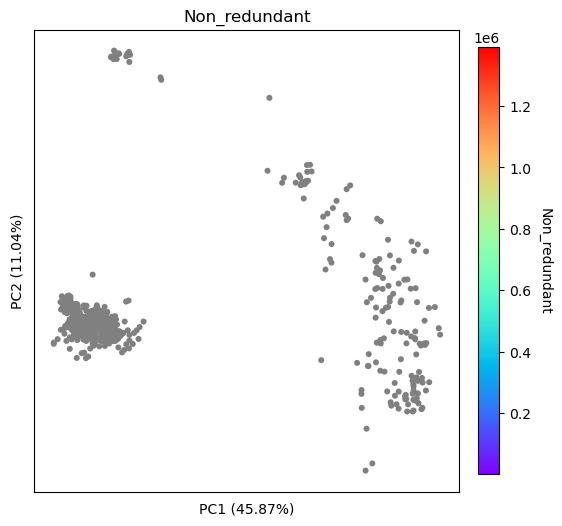

In [7]:
run_pca(adata)

In [ ]:

# Run PCA and visualize data
pca = PCA(n_components=subset_matrix.shape[1])
adata.obsm["X_pca"] = pca.fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_pca")
sc.tl.umap(adata, n_components=2, metric="cosine")

# Import Seurat library
import scanpy as sc

# Load data
adata = sc.read_h5ad('your_file.h5ad')

# Run PCA
sc.pp.pca(adata, use_highly_variable=True)

# Visualize PCA results
sc.pl.pca(adata, color='ORF_nonredundant_counts')

# Select PCs for UMAP
sc.pl.pca_variance_ratio(adata)
sc.tl.pca(adata, n_comps=21)
sc.pl.pca_variance_ratio(adata, log=True)

# Run UMAP
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=21)
sc.tl.umap(adata)

# Visualize UMAP results
sc.pl.umap(adata, color='ORF_nonredundant_counts')


In [ ]:
emb_matrix.dtype.names

Note that some of the code in the original R script, such as saving plots to a PDF file, will need to be modified or removed for use in Python.

In [ ]:
# Import Seurat library
import scanpy as sc
import matplotlib.pyplot as plt

# Define a function to load data
def load_data(filename):
    return sc.read_h5ad(filename)



# Define a function to visualize PCA results
def plot_pca(data):
    sc.pl.pca(data, color='ORF_nonredundant_counts')

# Define a function to select PCs for UMAP
def select_pcs(data):
    sc.tl.pca(data, n_comps=21)
    sc.pl.pca_variance_ratio(data, log=True)
    return data

# Define a function to run UMAP
def run_umap(data):
    sc.pp.neighbors(data, n_neighbors=30, n_pcs=21)
    sc.tl.umap(data)
    return data

# Define a function to visualize UMAP results
def plot_umap(data):
    sc.pl.umap(data, color='ORF_nonredundant_counts')

# Load data
adata = load_data('your_file.h5ad')

# Run PCA
adata = run_pca(adata)

# Visualize PCA results
plot_pca(adata)

# Select PCs for UMAP
adata = select_pcs(adata)

# Run UMAP
adata = run_umap(adata)

# Visualize UMAP results
plot_umap(adata)

# Save UMAP plot as a PDF file
plt.savefig('UMAP_1_2_plot.pdf', format='pdf', dpi=300)

In [ ]:
This code defines functions for loading data, running PCA, visualizing PCA results, selecting PCs for UMAP, running UMAP, visualizing UMAP results, and saving a UMAP plot as a PDF file.
The main code loads the data, runs PCA, visualizes PCA results, selects PCs for UMAP, runs UMAP, visualizes UMAP results, and saves a U